**This notebook is the executable version of lab note 3.
It answers the following questions:**

Finally, we answer 4 items:

    1. Are successful creators more connected to high-outdegree users than do unsuccessful creators?
    2. Are mavens more connected to successful creators than to unsuccessful creators?
    3. Do successful creators send more non-follow actions towards mavens than to zombies?
    4. Do successful creators send more non-follow actions towards mavens than to stars?

    

In [1]:
#Run parameters
#used to control every run. Can be user to perfom sensitivity checks
path_dir = r"/Users/../Volumes/Raw/"

In [2]:
import sys  
import pickle
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
import src.utils
from collections import Counter
from src.utils import import_dta, import_tracks_dta,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import numpy as np
import datetime
import pandas as pd
from tqdm import tqdm
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import os
from statsmodels.stats.proportion import proportions_ztest

In [3]:
def process_date(date):
    '''convert date format like '2013-w09' to '2013-03-04', i.e. the first day of that week'''
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.datetime.strptime(date, "%Y-%W-%w")
    return dt

# Data Imports

We start by importing the raw data.  `follows_sent`, `comments_sent`, `shares_sent`, `likes_sent` and `messages_sent` contains data pn the promotional activities that the 35k users tracked in the dataset directed to other users. It includes the `user_id`, the `fan_id` and the `date_sent` which identifies the date when the prom. activity was sent. `users_info_1st` shows the type of user (creator or non-creator, which is identified by a blank) and the date the user entered the platform, for every user that sent or received prom. activities from any of the 35k users tracked in this dataset, while `users_info` contains the same information, but pertaining to the 35k users themselves.

`follows_received` contains information on the follows received by the 35k users and will be used to generate the successful/unsuccessful groups of content creators.

In [4]:
#affiliations :follows
#favoritings :likes

#used in filtering:
path_dir = r"/Users/../Volumes/Raw/"
tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");

#Used to track information on the 1st degree connections
user_info_1st = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info_1st.columns = ['user_id', 'type', 'entered_platform'];
user_info = import_dta(path_dir, "12sample_user_infos.dta");

#Used to compute creator's success measure
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)


# Preprocessing

## Creator ids, successful and unsucessful creators

Next, we define three lists of ids: one with the ids from the content creators, according to the `users_info` table, one with the ids of successful creators and the last one with the ids of the unsuccessful ones.

Let's start with a list of the id of creators. We also create a dataset with containing information on creators only.

In [5]:
mask = (tracks.track_available == 1) & (tracks.public == 't')
creator_ids = tracks[mask].user_id.unique()

creators = tracks[(tracks.track_available == 1) & (tracks.public == 't')]

#mask = user_info.type == 'creator'
#creator_ids = user_info[mask].user_id.unique()

#creators = user_info[user_info.type == 'creator']

In [6]:
follows_received['day'] = follows_received.created_at.dt.floor('d')

In [7]:
mask = follows_received.contact_id.isin(creator_ids)
follows_day = follows_received.loc[mask].groupby(['contact_id', 'day']).fan_id.count()
follows_day = follows_day.groupby(level=0).cumsum().reset_index()
follows_day.columns = ['creator', 'day', 'cummulative_followers']

ValueError: The number of FixedLocator locations (13), usually from a call to set_ticks, does not match the number of ticklabels (6).

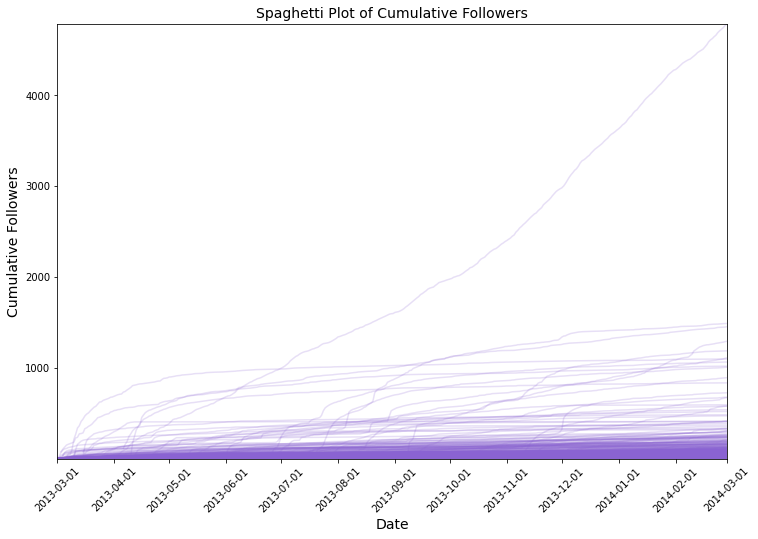

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

max_date = 12
nice_purple = '#8a63d2'
nice_pink = '#FFC0CB'

# Assuming your dataset is stored in a DataFrame called 'follows_day'
# Make sure the 'day' column is of type datetime
follows_day['day'] = pd.to_datetime(follows_day['day'])

# Get unique creators in the dataset
creators = follows_day['creator'].unique()

# Set up the figure and axes with increased size
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate over each creator and plot the line
for creator in creators:
    creator_data = follows_day[follows_day['creator'] == creator]
    ax.plot(creator_data['day'], creator_data['cummulative_followers'], label=f'Creator {creator}',
            alpha = 0.2, color = nice_purple)

# Set labels and title
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('Cumulative Followers', fontsize = 14)
ax.set_title('Spaghetti Plot of Cumulative Followers', fontsize = 14)

# Set x-axis limits to the first 6 months
start_date = follows_day['day'].min()
end_date = start_date + pd.DateOffset(months=max_date)
ax.set_xlim(start_date, end_date)

ax.fill_between(creator_data['day'], 2000)

# Get the maximum value of cummulative_followers in the first 6 months
max_followers = follows_day[(follows_day['day'] >= start_date) & (follows_day['day'] <= end_date)]['cummulative_followers'].max()

# Set y-axis limits based on the maximum value of cummulative_followers
ax.set_ylim(1, max_followers)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)
months = ['Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5', 'Month 6']
ax.set_xticks(pd.date_range(start_date, end_date, freq='MS'))
ax.set_xticklabels(months, rotation=45)

# Show the plot
plt.savefig('images/spaghetti_plot.png')
plt.show()


In [22]:
!pwd

/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/notebooks


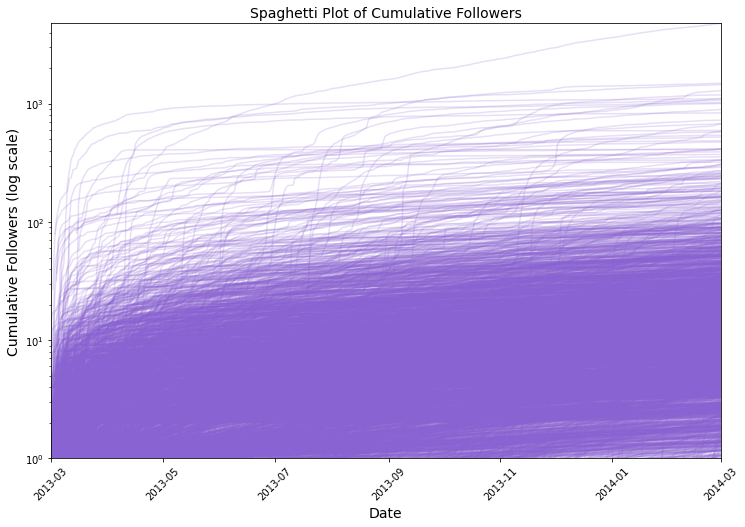

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your dataset is stored in a DataFrame called 'follows_day'
# Make sure the 'day' column is of type datetime
follows_day['day'] = pd.to_datetime(follows_day['day'])

# Get unique creators in the dataset
creators = follows_day['creator'].unique()

# Set up the figure and axes with increased size
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate over each creator and plot the line
for creator in creators:
    creator_data = follows_day[follows_day['creator'] == creator]
    ax.plot(creator_data['day'], creator_data['cummulative_followers'], label=f'Creator {creator}',
        alpha = 0.2, color = nice_purple)

# Set labels and title
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('Cumulative Followers (log scale)', fontsize = 14)
ax.set_title('Spaghetti Plot of Cumulative Followers', fontsize = 14)

# Set y-axis to log scale
ax.set_yscale('log')

# Set x-axis limits to the first 6 months
start_date = follows_day['day'].min()
end_date = start_date + pd.DateOffset(months=max_date)
ax.set_xlim(start_date, end_date)

# Get the maximum value of cummulative_followers in the first 6 months
max_followers = follows_day[(follows_day['day'] >= start_date) & (follows_day['day'] <= end_date)]['cummulative_followers'].max()

# Set y-axis limits based on the maximum value of cummulative_followers
ax.set_ylim(1, max_followers)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()


# Classify starts and ordinary

In [113]:
import pandas as pd

# Assuming your table data is stored in a pandas DataFrame called 'df'

# Convert the 'day' column to datetime if it's not already in datetime format
df['day'] = pd.to_datetime(df['day'])

# Filter the rows based on the condition
filtered_df = df[df['day'] <= '2013-04-07'].sort_values(by='day', ascending=False).groupby('creator').first()

# Display the resulting rows
print(filtered_df)

                day  cummulative_followers  increase
creator                                             
37824072 2013-04-07                      4       1.0
37824662 2013-03-03                      3       1.0
37824681 2013-04-07                     66       3.0
37825346 2013-03-22                      3       1.0
37825479 2013-03-18                      3       1.0
...             ...                    ...       ...
38501511 2013-04-07                      2       1.0
38501678 2013-03-29                      5       1.0
38502111 2013-03-11                      6       1.0
38502288 2013-03-29                      6       1.0
38502509 2013-04-04                      2       1.0

[1562 rows x 3 columns]


In [117]:
import pandas as pd
import numpy as np

# Assuming your table data is stored in a pandas DataFrame called 'df'

# Calculate the percentile distribution
percentiles = np.percentile(filtered_df['cummulative_followers'], np.arange(0, 101, 1))

# Create a DataFrame to display the percentile distribution
percentile_df = pd.DataFrame({'Percentile': np.arange(0, 101, 1), 'Value': percentiles})

# Display the percentile distribution
print(percentile_df)

     Percentile   Value
0             0    2.00
1             1    2.00
2             2    2.00
3             3    2.00
4             4    2.00
..          ...     ...
96           96   25.00
97           97   32.00
98           98   49.56
99           99  103.95
100         100  742.00

[101 rows x 2 columns]


In [124]:
filtered_df.loc[filtered_df.cummulative_followers >= 500]

,day,cummulative_followers,increase
creator,,,
38027041,2013-04-07,562,6.0
38183207,2013-04-07,742,7.0


In [ ]:
import pickle

follows_received_alters_succ = pd.read_pickle('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/Data/follows_received_by_alters_of_successful_creators.pkl')


In [5]:
follows_received_alters_succ

,contact_id,fan_id,created_at
0,8,15,2007-07-28
1,8,235,2007-09-27
2,9,351,2007-10-09
3,2,323,2007-10-10
4,2,235,2007-10-19
...,...,...,...
106909,89152418,129411633,2015-07-13
106910,154325247,129411633,2015-07-13
106911,31477668,129411633,2015-07-13
106912,11458541,129411633,2015-07-13


In [7]:
follows_received_alters_succ.loc[follows_received_alters_succ.fan_id == 129411633].iloc[-2,2]

Timestamp('2015-07-13 00:00:00')

In [ ]:
datetime(2015, 7, 13)

In [9]:
#data should be 
def followers_up_to(user_id, date, data):
    data = data.loc[(data.contact_id==user_id)&(data.created_at <= date)].groupby('contact_id').fan_id.apply(np.array)
    return data

In [68]:
def followers_up_to_fast(user_id, date, data):
    
    filtered_data = data[(data['contact_id'] == user_id) & (data['created_at'] <= date)]
    followers = filtered_data.loc[filtered_data['contact_id'] == user_id, 'fan_id'].to_numpy()
    
    return followers

In [45]:
follows_received_alters_suc

,contact_id,fan_id,created_at
0,8,15,2007-07-28
1,8,235,2007-09-27
2,9,351,2007-10-09
3,2,323,2007-10-10
4,2,235,2007-10-19
...,...,...,...
106909,89152418,129411633,2015-07-13
106910,154325247,129411633,2015-07-13
106911,31477668,129411633,2015-07-13
106912,11458541,129411633,2015-07-13


In [56]:
def get_partitions(start_date, end_date, interval = 7):
    partitions = []
    current_date = start_date

    while current_date < end_date:
        partitions.append(current_date)
        current_date += timedelta(days=interval)

    return partitions

In [60]:
from datetime import timedelta
start_date = datetime.datetime(2013, 5, 30, 0, 0)
end_date = datetime.datetime(2015, 5, 30, 0, 0)

In [117]:
import time

#f= followers_up_to
f= followers_up_to_fast

# Start the timer
start_time = time.time()

# Call the function

for week_start in get_partitions(start_date, end_date):
    
            try: 
                fan_followers = f(154325247, week_start
                            ,new_df).values[0]
            except:
                pass


# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 6.239707946777344 seconds


In [118]:
import time

f= followers_up_to
#f= followers_up_to_fast

# Start the timer
start_time = time.time()

# Call the function
for week_start in get_partitions(start_date, end_date):
    
            try: 
                fan_followers = f(154325247, week_start
                            ,new_df).values[0]
            except:
                pass

# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 5.780503034591675 seconds


In [97]:
date_lim = datetime.datetime(2013, 3, 1, 0, 0)
concate = follows_received_alters_succ.loc[follows_received_alters_succ.created_at <= date_lim]\
.groupby(['contact_id'], as_index = False).fan_id.apply(np.array)
#concate['created_at'] = datetime.datetime(2013, 3, 1, 0, 0)

In [99]:
concate =concate.reset_index()

In [101]:
concate.columns = ['contact_id', 'fan_id']
concate['created_at'] = datetime.datetime(2013, 3, 1, 0, 0)

In [102]:
concate

,contact_id,fan_id,created_at
0,0,"[323, 235, 1095, 1030, 2227, 45, 111, 5212, 59...",2013-03-01
1,1,"[15, 235, 569, 616, 896, 1030, 1239, 323, 111,...",2013-03-01
2,2,"[351, 2227, 45, 5212, 7819, 5905, 55, 91, 1550...",2013-03-01
3,3,"[45, 3944, 4564, 4835, 7800, 5905, 14221, 1348...",2013-03-01
4,4,"[45, 5905, 1148, 1660, 870, 748, 2664, 1119, 4...",2013-03-01
...,...,...,...
36316,36316,"[28829199, 37777842]",2013-03-01
36317,36317,"[18958577, 7644210, 26656720, 34355795, 720616...",2013-03-01
36318,36318,"[9386369, 8188765, 30716152, 37920097]",2013-03-01
36319,36319,[37892422],2013-03-01


In [107]:
follows_received_alters_succ_filter =  follows_received_alters_succ.loc[follows_received_alters_succ.created_at > date_lim]
new_df =  pd.concat([follows_received_alters_succ_filter, concate])

In [109]:
date_lim = datetime.datetime(2013, 5, 1, 0, 0)

teste = new_df.loc[new_df.created_at <= date_lim]\
.groupby(['contact_id'], as_index = False).fan_id.apply(np.array)

In [116]:
teste.iloc[100]

array([array([   43902,    55618,     2664,    64807,    19139,    61712,
                 51305,    11170,     5720,      244,    73445,    77987,
                 62792,    62264,    98906,    95940,    47318,    16836,
                 53680,    35699,    63274,      317,    73396,    14912,
                  5135,     5756,   157439,     4610,   333275,   113435,
                 19710,    84207,    75687,    36202,     8133,   206098,
                 75862,    12613,     9206,      595,   127674,   298135,
                 29984,    92399,    79765,     4459,     3160,    83136,
                 71909,     5453,    27359,   109096,    55616,   150765,
                 66072,   459917,   144987,   658220,    61852,    37572,
                 95170,   218724,   187166,   172615,    48794,    58723,
                263149,   156665,    73554,   137298,   232183,    78464,
                 92689,   206057,   197825,   531619,   168885,   103586,
                215166,   680100,   47